In [1]:
import pandas as pd
import numpy as np
import os, math, json, time, datetime
#from pyspark.sql import SparkSession, functions, window
#from pyspark.sql.types import StringType
#from pyspark.sql.types import StructType
#from pyspark.conf import SparkConf
#from pyspark.sql import functions as func
#from pyspark.sql.window import Window
#from pyspark import SparkContext
#from pyspark import SparkConf,SparkContext,HiveContext
#from pyspark.sql import SQLContext
#from pyspark.sql import SparkSession
#from pyspark.sql import Row
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, make_scorer
import seaborn as sns


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse

In [2]:
df = pd.read_csv('data.csv',sep=';')

In [3]:
df.head()

,Periode,Demand
0,31/01/2018,34890
1,28/02/2018,25830
2,31/03/2018,41054
3,30/04/2018,36838
4,31/05/2018,56808


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Periode  76 non-null     object
 1   Demand   76 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ KB


In [5]:
df['Demand'] = df['Demand'].astype('float')
df['Periode'] = pd.to_datetime(df['Periode'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Periode  76 non-null     datetime64[ns]
 1   Demand   76 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.3 KB


In [7]:
df.head()

,Periode,Demand
0,2018-01-31,34890.0
1,2018-02-28,25830.0
2,2018-03-31,41054.0
3,2018-04-30,36838.0
4,2018-05-31,56808.0


<AxesSubplot:xlabel='Periode', ylabel='Demand'>

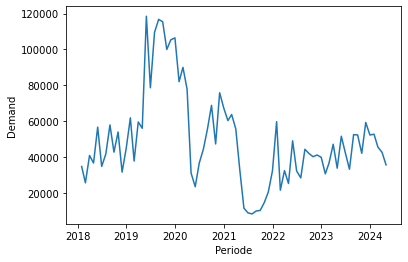

In [8]:
sns.lineplot(x='Periode',y='Demand',data=df)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

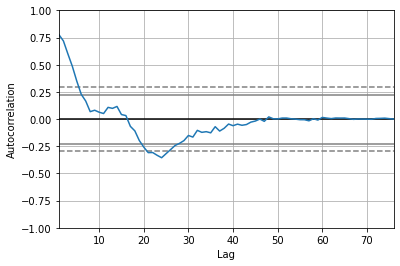

In [9]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['Demand'])

In [ ]:
# cannot see the seasonality in the lag

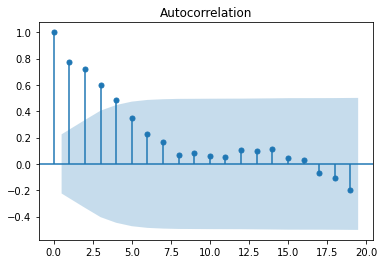

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['Demand'])
plt.show()

* A sharp cutoff in the ACF plot at a particular lag suggests that a time series model with a corresponding number of lags would be a good fit.
* A slowly decaying ACF plot may indicate the presence of a trend in the data.

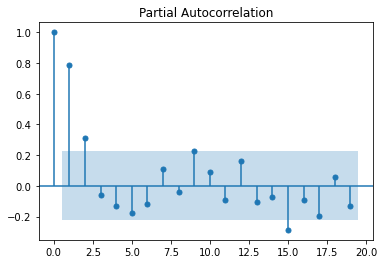

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['Demand'])
plt.show()

A slowly decaying PACF plot may indicate the presence of seasonality in the data.
A sharp cutoff in the PACF plot at a particular lag may indicate the presence of a seasonal pattern in the data.

In [32]:
df2 = df.copy()

In [33]:
df2.index = df2['Periode']

df2 = df2.drop(['Periode'], axis=1)

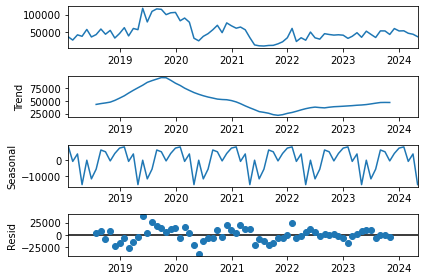

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(df2,model='additive',period=12)
decomposition.plot()
plt.show()

In [13]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ad_fuller(timeseries):
    print ('Dickey-Fuller Test indicates:')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)

print(ad_fuller(df['Demand']))

Dickey-Fuller Test indicates:
Test Statistic                 -2.821409
p-value                         0.189192
#Lags Used                      4.000000
Number of Observations Used    71.000000
dtype: float64
None


p-value < 0.05 indicating that our time series is stationary. (Reject the  null hypothesis)

p-value >= 0.05 indicating that our time series is non stationary.

# SARIMA

In [14]:
#train_data =  df[(df['Periode'] < '2023-05-01')&(df['Periode'] >= '2022-05-01')]
#train_data =  df[(df['Periode'] < '2023-05-01')&(df['Periode'] >= '2021-05-01')]
train_data =  df[df['Periode'] < '2023-05-01']
test_data = df[df['Periode'] >= '2023-05-01']

In [ ]:
#find the best order for p,d q

In [ ]:
#optimization

import pmdarima as pmd

model=pmd.auto_arima(df['Demand'],start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

In [15]:
train_data.index = train_data['Periode']
test_data.index = test_data['Periode']

train_data = train_data.drop(['Periode'], axis=1)
test_data = test_data.drop(['Periode'], axis=1)

In [16]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
 
# Load your time series data
# Assuming 'data' is a pandas Series or DataFrame with datetime index
# Replace 'data.csv' with your data file path if loading from file
# data = pd.read_csv('data.csv', index_col='Date', parse_dates=True)

 
# Define the range of values for SARIMA parameters
p_range = range(0, 3)  # AR order
d_range = range(0, 2)  # Differencing order
q_range = range(0, 3)  # MA order
P_range = range(0, 3)  # Seasonal AR order
D_range = range(0, 2)  # Seasonal differencing order
Q_range = range(0, 3)  # Seasonal MA order
s = 12  # Seasonal period (e.g., 12 for monthly data)
 
# Generate all possible combinations of SARIMA parameters
parameters_grid = product(p_range, d_range, q_range, P_range, D_range, Q_range)
 
# Perform grid search optimization
best_model = None
best_rmse = np.inf
for params in parameters_grid:
    try:
        
        sarima_model = SARIMAX(train_data, order=params[:3], seasonal_order=params[3:] + (s,))
        sarima_result = sarima_model.fit(disp=False)
        forecast = sarima_result.forecast(len(train_data))  # Forecast the entire series for evaluation
        rmse = np.sqrt(mean_squared_error(train_data, forecast))
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = sarima_result
            best_params = params
    except:
        continue
 
# Print the best model and parameters
print("Best SARIMA Model:")
print(best_model.summary())
print("Best Parameters:", best_params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible start

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\sta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\sta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\sta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\sta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\sta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\sta

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1008: UserWarning: Non-invertible start

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarim

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations 

Best SARIMA Model:
                                      SARIMAX Results                                      
Dep. Variable:                              Demand   No. Observations:                   64
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 12)   Log Likelihood                -698.904
Date:                             Wed, 15 May 2024   AIC                           1409.807
Time:                                     11:50:47   BIC                           1422.666
Sample:                                 01-31-2018   HQIC                          1414.865
                                      - 04-30-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5478      0.187      2.925      0.003       0.181       0.915
ar.L2   

In [ ]:
#p, d, q = best_order

In [ ]:
# Example: Predict next value
#last_observed_values = cek[-len(best_result.params):]
#last_observed_values = cek[-(p+d):]
#last_errors = best_result.resid[-len(best_result.params):]
#next_prediction = arima_prediction(best_result.params, best_result.params[-1], last_observed_values, last_errors)
#print("Next Prediction:", next_prediction)

In [18]:
# SARIMA model fitting
order = (2, 1, 1)  # Replace with appropriate SARIMA order
seasonal_order = (2, 0, 0,12)  # Replace with appropriate seasonal order
sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [19]:
# Summary of the SARIMA model
print(sarima_result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              Demand   No. Observations:                   64
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 12)   Log Likelihood                -698.904
Date:                             Wed, 15 May 2024   AIC                           1409.807
Time:                                     11:52:11   BIC                           1422.666
Sample:                                 01-31-2018   HQIC                          1414.865
                                      - 04-30-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5478      0.187      2.925      0.003       0.181       0.915
ar.L2          0.3170      

In [30]:
test_data['prediction'] = sarima_result.forecast(steps=len(test_data)).values
test_data.loc[test_data['prediction'] < 0, 'prediction']=0

In [31]:
test_data['abs_error'] = abs(test_data['prediction']- test_data['Demand'])
test_data['error'] = test_data['prediction']- test_data['Demand']

In [20]:
train_data['prediction'] = sarima_result.forecast(steps=len(train_data)).values
train_data.loc[train_data['prediction'] < 0, 'prediction']=0

train_data['abs_error'] = abs(train_data['prediction']- train_data['Demand'])
train_data['error'] = train_data['prediction']- train_data['Demand']

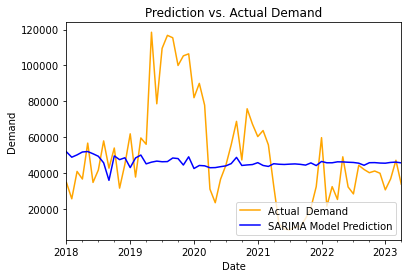

In [21]:
train_data['Demand'].plot(label='Actual  Demand', color='orange')
train_data['prediction'].plot(label='SARIMA Model Prediction', color='blue')
plt.title("Prediction vs. Actual Demand")
plt.xlabel('Date')
plt.ylabel('Demand')

plt.legend(loc='lower right')

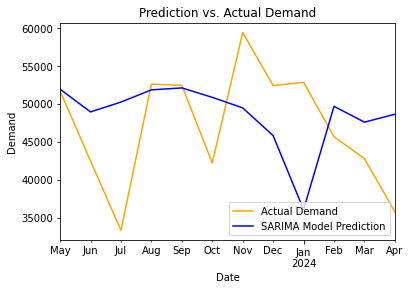

In [25]:
test_data['Demand'].plot(label='Actual Demand', color='orange')
test_data['prediction'].plot(label='SARIMA Model Prediction', color='blue')
plt.title("Prediction vs. Actual Demand")
plt.xlabel('Date')
plt.ylabel('Demand')

plt.legend(loc='lower right')

In [26]:
test_data['abs_error'].mean()

7353.224176424524

In [27]:
(test_data['abs_error']/test_data['Demand']).mean()

0.1713883470197306

In [28]:
test_data['error'].sum()

19534.550003691016

In [40]:
train_data[train_data.index>='2022-05-01']['abs_error'].mean()

7528.1367411370775

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information

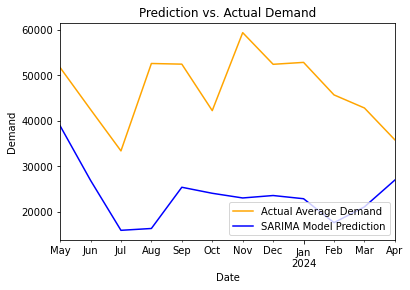

In [29]:
#Training the model again after each prediction, making one-step-ahead prediction each time
one_step_predictions = []
for i in range(12):
    
    cut_point = train_data['Demand'].size - 1 + i
    model = SARIMAX(train_data['Demand'][:cut_point],
                         order=(0, 0, 2),
                         seasonal_order=(1, 0, 0,12),
                         enforce_stationarity=False,
                         enforce_invertibility=False)
    result = model.fit()
    one_step_predictions.append(result.predict(cut_point).values[0])

test_data['prediction'] = one_step_predictions
test_data.loc[test_data['prediction'] < 0, 'prediction']=0
#test_data.set_index('Periode', inplace=True)
test_data['Demand'].plot(label='Actual Average Demand', color='orange')
test_data['prediction'].plot(label='SARIMA Model Prediction', color='blue')
plt.title("Prediction vs. Actual Demand")
plt.xlabel('Date')
plt.ylabel('Demand')

plt.legend(loc='lower right')

In [ ]:
# Iterate through the data and perform one-step prediction
predictions = []
for i in range(len(data)):
    if i == 0:
        continue
    current_data = data[:i]
    model = ARIMA(current_data, order=(5,1,0))  # Example order
fitted_model = model.fit()
    prediction = fitted_model.forecast(steps=1)[0]
    predictions.append(prediction)
 
# Plot actual vs predicted values
plt.plot(data.index[1:], data[1:], label='Actual')
plt.plot(data.index[1:], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA One-Step Prediction')
plt.legend()
plt.show()

In [ ]:
sarima_result.forecast(steps=len(test_data)).values

In [ ]:
test_data['prediction'] = sarima_result.forecast(steps=len(test_data['Demand'])).values

In [ ]:
test_data

In [ ]:
test_data['abs_error'] = abs(test_data['prediction']- test_data['Demand'])
test_data['error'] = test_data['prediction']- test_data['Demand']

In [ ]:
test_data['abs_error'].mean()

In [ ]:
test_data['error'].sum()

In [ ]:
test_data

In [ ]:
# Forecasting with SARIMA
forecast_steps = 12  # Number of steps ahead to forecast
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()